## This file shows the whole analysis for the ANET Stock for 2-3 days with high-frequency trading from 9:30 am to 4 pm

#### The code reads a CSV file, renames its columns, and converts the Timestamp column to datetime format in a Pandas DataFrame for the stock data of ticker ANET on June 06, 2014, with minute-level OHLCV information.

In [76]:
import pandas as pd
from datetime import timedelta

# Read the stock market data from the CSV file
input_csv_file = "sp500_tickers_A-D_1min_1pppix/ANET_1min.txt"
dff = pd.read_csv(input_csv_file)

dff['Timestamp'] = pd.to_datetime(dff['2014-06-06 09:52:00'])
dff.rename(columns={'13.8125': 'Open', '14.1475': 'High', '13.8125.1': 'Low', '14.1275': 'Close', '5761904': 'Volume'}, inplace=True)
dff.drop(['2014-06-06 09:52:00'], axis =1) # Drop the existing data and time column as separated column is available
dff = dff[['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']] # Rearranging the columns in a particular order

print(dff.head())


            Timestamp     Open     High      Low    Close   Volume
0 2014-06-06 09:53:00  14.1275  14.1450  13.8500  13.9725  1127432
1 2014-06-06 09:54:00  13.9725  14.1850  13.8750  14.1775  1030860
2 2014-06-06 09:55:00  14.1675  14.1875  14.0500  14.1850   716264
3 2014-06-06 09:56:00  14.1600  14.2500  14.0700  14.2300   678156
4 2014-06-06 09:57:00  14.2125  14.2500  14.1275  14.1550   340516


In [77]:
start_time = pd.to_datetime("2016-10-18 09:30:00")
end_time = pd.to_datetime("2016-10-18 16:02:00")
#which_date = pd.to_datetime("").date()
dff2 = dff.loc[(dff['Timestamp'] >= start_time) & (dff['Timestamp'] <= end_time)]# Filtering values from 9:30 am to 4 pm on a particular date
print(dff2)

                 Timestamp     Open     High      Low    Close  Volume
192216 2016-10-18 09:30:00  20.4175  20.4175  20.4175  20.4175    9292
192217 2016-10-18 09:32:00  20.2600  20.2600  20.2600  20.2600     520
192218 2016-10-18 09:34:00  20.4200  20.4200  20.4200  20.4200     400
192219 2016-10-18 09:37:00  20.4175  20.4200  20.4175  20.4195    1628
192220 2016-10-18 09:42:00  20.4000  20.4050  20.3800  20.3800    3400
...                    ...      ...      ...      ...      ...     ...
192435 2016-10-18 15:56:00  20.2450  20.2475  20.2425  20.2425    5464
192436 2016-10-18 15:57:00  20.2425  20.2475  20.2425  20.2450    4000
192437 2016-10-18 15:58:00  20.2475  20.2475  20.2325  20.2350   11796
192438 2016-10-18 15:59:00  20.2350  20.2350  20.2050  20.2125   37852
192439 2016-10-18 16:02:00  20.2150  20.2150  20.2150  20.2150   69092

[224 rows x 6 columns]


### To fill in the data for missing timesteps we use linear extrapolation to calculate the prices for that timestamps and thus avoid any error or unexpected results

In [78]:
# Define a function for linear extrapolation
def linear_extrapolate(before, after, target_timestamp):
    time_diff = (target_timestamp - before['Timestamp']).total_seconds() / 60  # Convert to minutes
    price_diff = after['Open'] - before['Open']
    estimated_price = before['Open'] + (price_diff / (after['Timestamp'] - before['Timestamp']).total_seconds() / 60) * time_diff
    return estimated_price

# Create a new DataFrame to store the extrapolated data
extrapolated_data = []

# Iterate through the DataFrame to fill in missing timestamps
for i in range(len(dff2) - 1):
    current_row = dff2.iloc[i]
    next_row = dff2.iloc[i + 1]
    time_diff = (next_row['Timestamp'] - current_row['Timestamp']).total_seconds() / 60  # Convert to minutes

    if time_diff > 1:
        for j in range(1, int(time_diff)):
            target_timestamp = current_row['Timestamp'] + timedelta(minutes=j)
            estimated_price = linear_extrapolate(current_row, next_row, target_timestamp)
            extrapolated_data.append([target_timestamp, estimated_price, estimated_price, estimated_price, estimated_price, 0])

# Append the extrapolated data to the original DataFrame
extrapolated_dff2 = pd.DataFrame(extrapolated_data, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
dff3 = pd.concat([dff2, extrapolated_dff2])
#Sorting according to the timestamps
dff3 = dff3.sort_values(by='Timestamp')
# Getting the data only till 4pm
dff3 = dff3[:-2]
print(dff3)

                 Timestamp       Open       High        Low      Close  Volume
192216 2016-10-18 09:30:00  20.417500  20.417500  20.417500  20.417500    9292
0      2016-10-18 09:31:00  20.417478  20.417478  20.417478  20.417478       0
192217 2016-10-18 09:32:00  20.260000  20.260000  20.260000  20.260000     520
1      2016-10-18 09:33:00  20.260022  20.260022  20.260022  20.260022       0
192218 2016-10-18 09:34:00  20.420000  20.420000  20.420000  20.420000     400
...                    ...        ...        ...        ...        ...     ...
192435 2016-10-18 15:56:00  20.245000  20.247500  20.242500  20.242500    5464
192436 2016-10-18 15:57:00  20.242500  20.247500  20.242500  20.245000    4000
192437 2016-10-18 15:58:00  20.247500  20.247500  20.232500  20.235000   11796
192438 2016-10-18 15:59:00  20.235000  20.235000  20.205000  20.212500   37852
167    2016-10-18 16:00:00  20.234998  20.234998  20.234998  20.234998       0

[391 rows x 6 columns]


### Using the mplfinance library to plot the candlestick plots

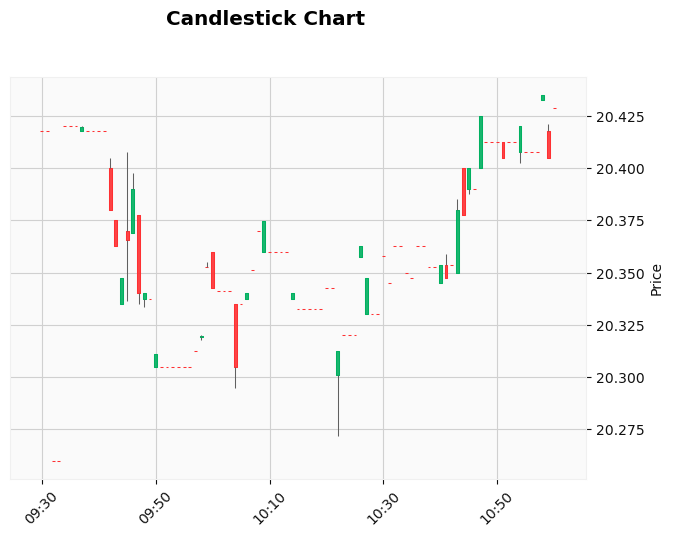

In [79]:
import mplfinance as mpf
end_time = pd.to_datetime("2016-10-18 11:00:00") # Setting the end-time
dff4 = dff3.loc[(dff3['Timestamp'] >= start_time) & (dff3['Timestamp'] <= end_time)]# Filtering values from 9:30 am to 4 pm on a particular date
dff4.set_index("Timestamp", inplace=True)
mpf.plot(dff4, type="candle", title="Candlestick Chart", style="yahoo")# Command to plot the chart with appropriate type and style

### Performing extrapolation for the next day also

In [80]:
extrapolated_data_next_day = []

start_time = pd.to_datetime("2016-10-19 09:30:00")
end_time = pd.to_datetime("2016-10-19 16:02:00")
dff_test_next_day = dff.loc[(dff['Timestamp'] >= start_time) & (dff['Timestamp'] <= end_time)]# Filtering values from 9:30 am to 4 pm on a particular date
# Iterate through the DataFrame to fill in missing timestamps
for i in range(len(dff_test_next_day) - 1):
    current_row = dff_test_next_day.iloc[i]
    next_row = dff_test_next_day.iloc[i + 1]
    time_diff = (next_row['Timestamp'] - current_row['Timestamp']).total_seconds() / 60  # Convert to minutes

    if time_diff > 1:
        for j in range(1, int(time_diff)):
            target_timestamp = current_row['Timestamp'] + timedelta(minutes=j)
            estimated_price = linear_extrapolate(current_row, next_row, target_timestamp)
            extrapolated_data_next_day.append([target_timestamp, estimated_price, estimated_price, estimated_price, estimated_price, 0])

# Append the extrapolated data to the original DataFrame
extrapolated_dff2_next_day = pd.DataFrame(extrapolated_data_next_day, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

dff3_next_day = pd.concat([dff_test_next_day, extrapolated_dff2_next_day])
dff3_next_day = dff3_next_day.sort_values(by='Timestamp')
dff3_next_day = dff3_next_day[:-2]
print(dff3_next_day)

                 Timestamp       Open       High        Low      Close  Volume
192440 2016-10-19 09:30:00  20.190000  20.190000  20.190000  20.190000   10244
192441 2016-10-19 09:31:00  20.276200  20.276200  20.266000  20.266000     904
192442 2016-10-19 09:32:00  20.287500  20.335000  20.250000  20.335000   10288
0      2016-10-19 09:33:00  20.287495  20.287495  20.287495  20.287495       0
1      2016-10-19 09:34:00  20.287490  20.287490  20.287490  20.287490       0
...                    ...        ...        ...        ...        ...     ...
192726 2016-10-19 15:56:00  20.505000  20.505000  20.487500  20.487500   18800
192727 2016-10-19 15:57:00  20.492500  20.492500  20.487500  20.487500    3600
192728 2016-10-19 15:58:00  20.485000  20.485000  20.474500  20.475000   10416
192729 2016-10-19 15:59:00  20.475000  20.477500  20.465000  20.475000   10700
100    2016-10-19 16:00:00  20.475000  20.475000  20.475000  20.475000       0

[391 rows x 6 columns]


### Rest of the process is same as in Apple_stock_Analysis.ipynb. Please refer it for detained explanation and comments in the rest of the code 

In [81]:
def normdata(data):
    mini = data.min()
    maxa = data.max()
    x = data

    y = (x- mini) / (maxa - mini)
    return y

In [82]:
dff3['Normalized_Close'] = normdata(dff3['Close'])
dff3['Normalized_Volume'] = normdata(dff3['Volume'])
dff3['Normalized_Open'] = normdata(dff3['Open'])
dff3['Normalized_High'] = normdata(dff3['High'])
dff3['Normalized_Low'] = normdata(dff3['Low'])

print(len(dff3['Normalized_Open']))
print(dff3['Normalized_Open'].head(50))

391
192216    0.845361
0         0.845271
192217    0.195876
1         0.195968
192218    0.855670
2         0.855669
3         0.855668
192219    0.845361
4         0.845357
5         0.845353
6         0.845349
7         0.845345
192220    0.773196
192221    0.670103
192222    0.505155
192223    0.649485
192224    0.644536
192225    0.680412
192226    0.515464
8         0.515445
192227    0.381443
9         0.381445
10        0.381446
11        0.381447
12        0.381448
13        0.381449
14        0.381451
192228    0.412371
192229    0.440000
192230    0.577320
192231    0.608247
192232    0.530722
15        0.530719
16        0.530717
192233    0.505155
17        0.505156
192234    0.515464
192235    0.571959
192236    0.649485
192237    0.608247
18        0.608242
19        0.608237
20        0.608232
21        0.608227
192238    0.515464
192239    0.494845
22        0.494848
23        0.494850
24        0.494852
25        0.494855
Name: Normalized_Open, dtype: float64


In [83]:
import torch
import torch.nn as nn

In [84]:
class LSTMModel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_d, output_d):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_d
        self.layer_dim = layer_d

        # LSTM model 
        self.lstm = nn.LSTM(input_d, hidden_d, layer_d, batch_first=True) 

        self.fc = nn.Linear(hidden_d, output_d)

    def forward(self, x):
    
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) 
        #out = torch.sigmoid(out)
        return out
    
input_dim = 4
hidden_dim = 600
output_dim = 1
layer_dim = 1

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

#step 4: calculating cross entropy loss
#loss_fn = nn.BCELoss()
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

#step 5: optimizer 
learning_rate = 0.03
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [85]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# Read data, convert to NumPy arrays
X = dff3[['Normalized_Open', 'Normalized_High', 'Normalized_Low', 'Normalized_Close']][:-1].to_numpy() # Converting the 4 columns into a 2-D Numpy array

y = dff3['Normalized_Close'][1:].to_numpy()
X = torch.tensor(X, dtype=torch.float32).reshape(X.shape[0], 1, -1)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

print(X.shape)
print(y)
# create DataLoader, then take one batch
loader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=50)
for X_batch, y_batch in loader:
    #print(y_batch)
    break

torch.Size([390, 1, 4])
tensor([[0.8468],
        [0.2041],
        [0.2042],
        [0.8571],
        [0.8571],
        [0.8571],
        [0.8551],
        [0.8469],
        [0.8469],
        [0.8469],
        [0.8469],
        [0.6939],
        [0.6224],
        [0.5612],
        [0.6347],
        [0.7347],
        [0.5306],
        [0.5306],
        [0.5204],
        [0.4131],
        [0.3878],
        [0.3878],
        [0.3878],
        [0.3878],
        [0.3878],
        [0.3878],
        [0.4184],
        [0.4482],
        [0.5816],
        [0.5408],
        [0.5355],
        [0.5355],
        [0.5355],
        [0.3878],
        [0.5102],
        [0.5306],
        [0.5763],
        [0.6531],
        [0.6727],
        [0.6122],
        [0.6122],
        [0.6122],
        [0.6122],
        [0.5306],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5408],
        [0.5408],
        [0.4184],
        [0.4490],
        [0.4490],
    

In [86]:
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
 
# train-test split for evaluation of the model
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=380/390, shuffle=False)
print(y_test)
# set up DataLoader for training set
loader = DataLoader(list(zip(X_train, y_train)), shuffle=False, batch_size=75)
 
# Train the model
n_epochs = 300
model.train()
for epoch in range(n_epochs):
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        #print(y_pred)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
# evaluate accuracy after training
model.eval()
y_pred = model(X_test)
print(y_pred)
y_pred = y_pred.detach().numpy()
y_test = y_test.detach().numpy()
print(((sum((y_pred - y_test)**2))**0.5)/len(X_test))

tensor([[0.1478],
        [0.1584],
        [0.1531],
        [0.1531],
        [0.1429],
        [0.1327],
        [0.1429],
        [0.1020],
        [0.0102],
        [0.1020]])
tensor([[0.1022],
        [0.1228],
        [0.1365],
        [0.1375],
        [0.1231],
        [0.1244],
        [0.1194],
        [0.1189],
        [0.1054],
        [0.0355]], grad_fn=<AddmmBackward0>)
[0.013653]


In [87]:


max_p_next_day = dff3_next_day['Close'].max()
min_p_next_day = dff3_next_day['Close'].min()

dff3_next_day['Normalized_Close'] = normdata(dff3_next_day['Close'])
dff3_next_day['Normalized_Volume'] = normdata(dff3_next_day['Volume'])
dff3_next_day['Normalized_Open'] = normdata(dff3_next_day['Open'])
dff3_next_day['Normalized_High'] = normdata(dff3_next_day['High'])
dff3_next_day['Normalized_Low'] = normdata(dff3_next_day['Low'])

X = dff3_next_day[['Normalized_Close', 'Normalized_High', 'Normalized_Low', 'Normalized_Close']][:390].to_numpy() # Converting the 5 columns into a 2-D Numpy array
y = dff3_next_day['Normalized_Close'][1:391].to_numpy()
#print(X)


X = torch.tensor(X, dtype=torch.float32).reshape(X.shape[0], 1, -1)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1, shuffle=False)

loader = DataLoader(list(zip(X_train, y_train)), shuffle=False, batch_size=75)
actual_price  = dff3_next_day['Close'][2:391]


model.eval()
y_pred = model(X_test)
predicted_price = y_pred*(max_p_next_day - min_p_next_day) + min_p_next_day
predicted_price = predicted_price.detach().numpy()
y_pred = y_pred.detach().numpy()
y_test = y_test.detach().numpy()
print(((sum((y_pred - y_test)**2))**0.5))
print(predicted_price.reshape(1,-1))
actual_price = actual_price.to_numpy()


[0.82981956]
[[20.253817 20.300863 20.273819 20.273813 20.227337 20.214859 20.207586
  20.187551 20.144484 20.154097 20.145088 20.088715 20.053146 20.040018
  20.053713 20.136148 20.135925 20.151224 20.138474 20.104239 20.12373
  20.110426 20.091293 20.114943 20.111038 20.094757 20.087437 20.132895
  20.138401 20.137186 20.104717 20.113937 20.103321 20.11224  20.11224
  20.113188 20.104874 20.125776 20.120335 20.120337 20.135925 20.144484
  20.155378 20.144484 20.144484 20.144485 20.156101 20.15428  20.15428
  20.166885 20.182644 20.18158  20.195927 20.194155 20.207045 20.214607
  20.224657 20.224356 20.205557 20.215075 20.217024 20.217026 20.225939
  20.215214 20.207558 20.208555 20.197763 20.197222 20.1991   20.21447
  20.213015 20.21447  20.219582 20.223085 20.234333 20.242952 20.230856
  20.22608  20.227272 20.237177 20.242947 20.247894 20.247894 20.247894
  20.247894 20.24431  20.225672 20.225416 20.22179  20.22325  20.22179
  20.227272 20.212362 20.198305 20.204283 20.198305 20.1

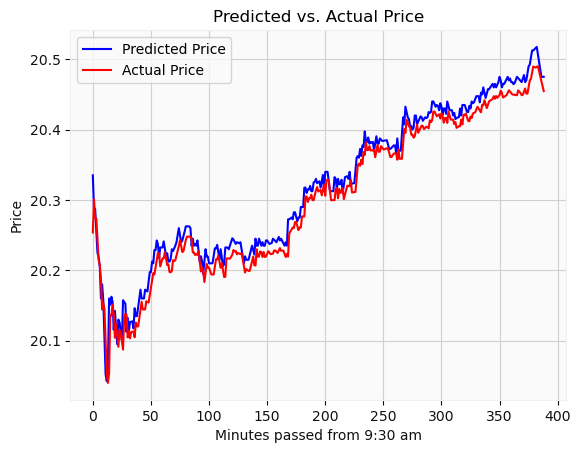

In [88]:
import matplotlib.pyplot as plt
t = np.arange(389) # Taking the data of 99 timestamps hence used this
plt.plot(t, actual_price , color = 'blue', label='Predicted Price') 
plt.plot(t, predicted_price, color = 'red', label='Actual Price')

# Adding labels and legend
plt.xlabel('Minutes passed from 9:30 am')
plt.ylabel('Price')
plt.title('Predicted vs. Actual Price')
plt.legend()

In [89]:
class TradingModule:
    def __init__(self, ema_period = 7):
        self.cash_balance = 100000  # Starting cash balance (100,000 in this example)
        self.qty = 0
        self.ema_period = ema_period
        self.ema_values = []  # Dictionary to store EMA values for each symbol
        self.commission = 0.0005 # Let the commission for trading be 0.05% of the total price of transaction made 
        self.bid_Ask = 0.0009 # Let the bid-ask spread be 0.09% of the total price of transaction made

    # Defining a function to calculate the Exponential Moving Average for the stock
    def calculate_ema(self, price):
        if len(self.ema_values) >= self.ema_period:
            self.ema_values.pop(0)
        
        self.ema_values.append(price)

        if len(self.ema_values) < self.ema_period:
            return None

        ema = sum(self.ema_values) / len(self.ema_values)
        return ema
    # Setting conditions when to buy or sell
    def buy(self, amount, price):
        if self.cash_balance >= (1 + self.commission + self.bid_Ask) * amount * price :
            self.qty += amount
            self.cash_balance -= (1 + self.commission + self.bid_Ask) * amount * price
            print(f"Bought {amount} shares of at ${price} each.")

    def sell(self, amount, price):
        if self.qty >= amount:
            self.qty -= amount
            self.cash_balance += (1 - self.commission - self.bid_Ask) * amount * price
            print(f"Sold {amount} shares at ${price} each.")

    def hold(self):
        pass  # Do nothing, simply hold existing positions
    

    def execute_strategy(self, current_price):
        ema = self.calculate_ema(current_price)
        if ema is not None:
            if current_price > ema:
                self.buy(125, current_price) # Buying and selling a fixed number of stocks every time i.e. 125
            elif current_price < ema:
                self.sell(125, current_price)
            else:
                self.hold()

    def outp(self):
        print(self.cash_balance)
        print(self.qty)


[100000.]
[100000.]
[100000.]
[100000.]
[100000.]
[100000.]
[100000.]
[100000.]
[100000.]
[100000.]
[100000.]
[100000.]
[100000.]
[100000.]
[100000.]
Bought 125 shares of at $[20.136148] each.
[99996.47607422]
Bought 125 shares of at $[20.135925] each.
[99992.92456055]
Bought 125 shares of at $[20.151224] each.
[99993.22265625]
Bought 125 shares of at $[20.138474] each.
[99984.91650391]
Sold 125 shares at $[20.104239] each.
[99964.28100586]
Bought 125 shares of at $[20.12373] each.
[99968.06884766]
Sold 125 shares at $[20.110426] each.
[99957.8972168]
Sold 125 shares at $[20.091293] each.
[99947.20629883]
Sold 125 shares at $[20.114943] each.
[99949.59863281]
Sold 125 shares at $[20.111038] each.
[99945.59106445]
[99945.59106445]
[99945.59106445]
Bought 125 shares of at $[20.132895] each.
[99942.06762695]
Bought 125 shares of at $[20.138401] each.
[99939.23144531]
Bought 125 shares of at $[20.137186] each.
[99935.40380859]
Sold 125 shares at $[20.104717] each.
[99919.70947266]
Sold 125

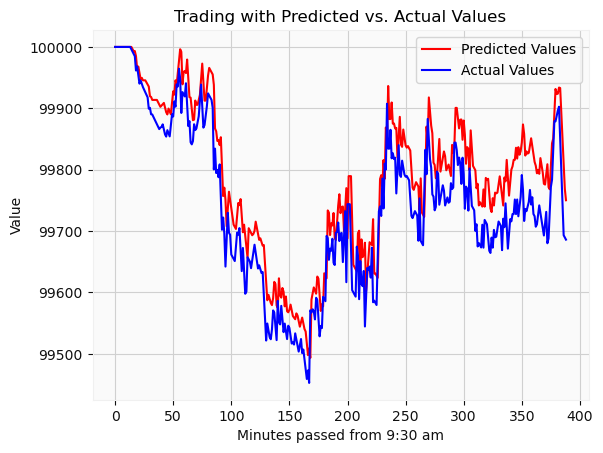

In [90]:
# Example usage:
if __name__ == "__main__":
    trading_module_pred = TradingModule()
    trading_module_actual = TradingModule()

L = [0]*389 # Predicted List
M = [0]*389 # Actual List
for i, price in enumerate(predicted_price):
    trading_module_pred.execute_strategy(price)

    TotalValues_predicted = trading_module_pred.cash_balance + price * trading_module_pred.qty
    L[i] = TotalValues_predicted
    print(TotalValues_predicted)

for i, price in enumerate(actual_price):
    trading_module_actual.execute_strategy(price)

    TotalValues_actual = trading_module_actual.cash_balance + price * trading_module_actual.qty
    M[i] = TotalValues_actual
    print(TotalValues_actual)
h = np.arange(389)
plt.plot(h, L, color='red', label='Predicted Values')
plt.plot(h, M, color='blue', label='Actual Values')

# Adding labels and legend
plt.xlabel('Minutes passed from 9:30 am')
plt.ylabel('Value')
plt.title('Trading with Predicted vs. Actual Values')
plt.legend()
